In [1]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(tf.__version__)

2.16.1


In [3]:
#@title Adjust the granularity of reporting
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [4]:
#@title Load the datasets
train_df =  pd.read_csv("datasets/california_housing_train.csv")
test_df = pd.read_csv("datasets/california_housing_test.csv")

In [4]:
# Observe train dataset
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


In [5]:
# Describe train dataset
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [5]:
# Shuffle the train dataset
train_df = train_df.reindex(np.random.permutation(train_df.index))
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10333,-120.1,34.6,11.0,586.0,125.0,317.0,74.0,2.9,84400.0
8881,-118.8,34.2,9.0,30405.0,4093.0,12873.0,3931.0,8.0,399200.0
320,-116.9,32.8,15.0,2053.0,321.0,993.0,309.0,5.5,248900.0
14311,-122.1,38.0,28.0,4308.0,824.0,2086.0,776.0,3.7,159700.0
7811,-118.4,34.0,49.0,1230.0,279.0,669.0,269.0,3.9,308300.0


## Preprocessing Data

In [6]:
# Keras input tensors of float values
inputs = {
    'latitude': tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='latitude'),
    'longitude': tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='longitude'),
    'median_income': tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='median_income'),
    'population': tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='population')
}


Objective of Normalization is to bring the values of a feature within a specific range, often between 0 and 1.

In [7]:
# Create a Normalization layer to normalize the median_income data
median_income = tf.keras.layers.Normalization(
    name='normalization_median_income',
    axis=None
)

# Adapt the normalization layer to the median_income data
median_income.adapt(np.array(train_df['median_income']))

# Apply the normalization layer to the median_income input feature
median_income = median_income(inputs['median_income'])

In [8]:
# Create a Normalization layer to normalize the population data.
population = tf.keras.layers.Normalization(
    name='normalization_population',
    axis=None
)
# Adapt the normalization layer to the population data
population.adapt(np.array(train_df['population']))
# Apply the normalization layer
population = population(inputs['population'])

Binning: it's better to use binning to represent longitude and latitude rather than using their floating number values. It's basically representing them in vector where each len(vector) = number of bins and if the longitude or latitude belongs to the bin then it's represented by 1 else 0.
for example we have 4 latitude bins, Our latitude belongs to the first bin 1<= latitude <= 5 then the vector representing our latitude will be [1,0,0,0].

In [9]:
# Create a list of numbers representing the bucket boundaries for latitude.
# Because we're using a Normalization layer, values for latitude and longitude
# will be in the range of approximately -3 to 3 (representing the Z score).
# We'll create 20 buckets, which requires 21 bucket boundaries (hence, 20+1)
latitude_boundaries = list(np.linspace(-3, 3, 20+1))
latitude_boundaries

[-3.0,
 -2.7,
 -2.4,
 -2.1,
 -1.8,
 -1.5,
 -1.2000000000000002,
 -0.8999999999999999,
 -0.6000000000000001,
 -0.30000000000000027,
 0.0,
 0.2999999999999998,
 0.5999999999999996,
 0.8999999999999999,
 1.2000000000000002,
 1.5,
 1.7999999999999998,
 2.0999999999999996,
 2.3999999999999995,
 2.7,
 3.0]

In [10]:
# Create a normalization layer to normalize the latitude data
latitude = tf.keras.layers.Normalization(
    name='normalization_latitude',
    axis=None
)
# Adapt the normalization layer to the latitude data
latitude.adapt(np.array(train_df['latitude']))
# Apply the normalization layer
latitude = latitude(inputs.get('latitude'))

In [11]:
# Create a Discretization layer to separate the latitude data into buckets
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude'
)(latitude)

In [12]:
# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.linspace(-3, 3 , 20+1))
longitude_boundaries

[-3.0,
 -2.7,
 -2.4,
 -2.1,
 -1.8,
 -1.5,
 -1.2000000000000002,
 -0.8999999999999999,
 -0.6000000000000001,
 -0.30000000000000027,
 0.0,
 0.2999999999999998,
 0.5999999999999996,
 0.8999999999999999,
 1.2000000000000002,
 1.5,
 1.7999999999999998,
 2.0999999999999996,
 2.3999999999999995,
 2.7,
 3.0]

In [13]:
# Create a normalization layer to normalize longitude
longitude = tf.keras.layers.Normalization(
    name='normalized_longitude',
    axis=None
)
longitude.adapt(np.array(train_df['longitude']))
longitude = longitude(inputs.get('longitude'))

In [14]:
# Create a Discretization layer to separate the longitude data into buckets
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude'
)(longitude)

In [15]:
# Cross the latitude and longitude features into a single one-hot vector
feature_cross = tf.keras.layers.HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude'
)([latitude, longitude])

In [16]:
# Concatenate our input into a single tensor
preprocessing_layers = tf.keras.layers.Concatenate()(
    [feature_cross, median_income, population]
)

## Build a linear regression model

In [17]:
# Plot Function
def plot_loss_curve(epochs, mse_training, mse_validation):
    """Plot a curve of loss vs. epoch."""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse_training, label="Training Loss")
    plt.plot(epochs, mse_validation, label="Validation Loss")

    # mse_training is a pandas Series, so convert it a list first
    merged_mse_lists = mse_training.tolist() + mse_validation
    highest_loss = max(merged_mse_lists)
    lowest_loss = min(merged_mse_lists)
    top_of_y_axis = highest_loss * 1.03
    bottom_of_y_axis = lowest_loss * 0.97

    plt.ylim([bottom_of_y_axis, top_of_y_axis])
    plt.legend()
    plt.show()

In [18]:
help(plot_loss_curve)

Help on function plot_loss_curve in module __main__:

plot_loss_curve(epochs, mse_training, mse_validation)
    Plot a curve of loss vs. epoch.



In [18]:
# Create the linear regression model
def create_model(inputs, outputs, learning_rate):
    """Create and compile a simple linear regression model."""
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Construct the layers into a model that Tensorflow can execute.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])
    return model


Define Normalized label columns

In [19]:
# Assuming train_df['median_house_value'] contains numerical data
median_house_value_data = np.array(train_df['median_house_value'])

# Reshape the data to match the expected shape of the normalization layer
median_house_value_data = median_house_value_data.reshape(-1)

# Adapt the normalization layer
train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
train_median_house_value_normalized.adapt(median_house_value_data)

In [20]:
# Assuming train_df['median_house_value'] contains numerical data
median_house_value_data = np.array(test_df['median_house_value'])

# Reshape the data to match the expected shape of the normalization layer
median_house_value_data = median_house_value_data.reshape(-1)
test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(
    median_house_value_data
)

In [21]:
# Create the train function of the model
def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
    """Feed a dataset into the model in order to train it"""
    # Split the dataset into features and label
    features = {name: np.array(value) for name, value in dataset.items()}
    label = train_median_house_value_normalized(np.array(features.pop(label_name)))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=validation_split)

    # Get model training details for plotting
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse, history.history

Define model outputs

In [22]:
def get_outputs_linear_regression():
    # Create the dense output layer.
    dense_output = tf.keras.layers.Dense(units=1, name='dense_output')(preprocessing_layers)
    # Define an output dictionary we'll send to the model constructor
    outputs = {
        'dense_output': dense_output
    }
    return outputs

Train the linear regression model

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.1088 - mean_squared_error: 1.1092 - val_loss: 0.8580 - val_mean_squared_error: 0.8580
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8448 - mean_squared_error: 0.8453 - val_loss: 0.6837 - val_mean_squared_error: 0.6818
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6872 - mean_squared_error: 0.6874 - val_loss: 0.5732 - val_mean_squared_error: 0.5704
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5777 - mean_squared_error: 0.5780 - val_loss: 0.5101 - val_mean_squared_error: 0.5072
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5161 - mean_squared_error: 0.5163 - val_loss: 0.4780 - val_mean_squared_error: 0.4756
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4894 - mean_squared_error: 0.4893 - val_loss: 0.4626 - val_mean_squared_error: 0.4608
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4712 - mean_squared_error: 0.4709 - val_loss: 0.4560 - val_mean

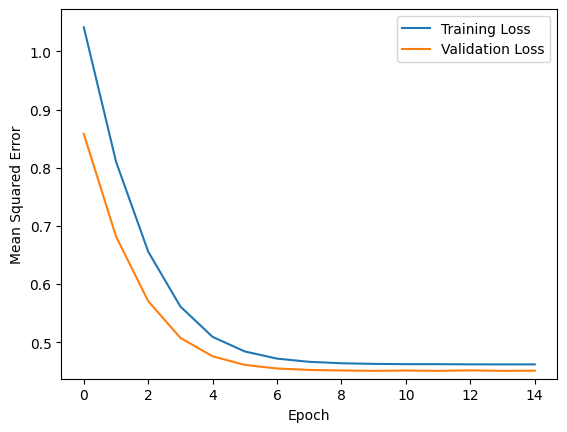

In [30]:
# Define hyperparameters
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Split the training set into a reduced training set and a validation set
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size, label_name, validation_split)

# Plot the curves
plot_loss_curve(epochs, mse, history["val_mean_squared_error"])

Evaluate the linear model

In [31]:
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(test_features.pop(label_name))
print('Evaluate the linear regression model against the test set:')
my_model.evaluate(x=test_features, y= test_label, batch_size=batch_size, return_dict=True)

Evaluate the linear regression model against the test set:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4752 - mean_squared_error: 0.4752  


{'loss': 0.4929349422454834, 'mean_squared_error': 0.4929349720478058}

## Build a Neural Network

get_outputs_dnn function the topography of the deep neural net(DNN), specifying the following:
- the number of layers in the deep neural network.
- the number of nodes (neurones) in each layer.

In [23]:
def get_outputs_dnn():
    # Create a Dense layer with 20 nodes.
    dense_output = tf.keras.layers.Dense(units=20, activation='relu', name='hidden_dense_layer_1')(preprocessing_layers)
    # Create a Dense layer with 12 nodes.
    dense_output = tf.keras.layers.Dense(units=12, activation='relu', name='hidden_dense_layer_2')(dense_output)
    # Create the Dense output layer.
    dense_output = tf.keras.layers.Dense(units=1, name='dense_output')(dense_output)
    # Define an output dictionary we'll send to the model constructor.
    outputs = {
        'dense_output': dense_output
    }
    return outputs

Build The Model

In [25]:
# define hyperparameters
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label name
label_name = "median_house_value"

# Split dataset into a reduced training set and validation set.
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model topography
my_model = create_model(inputs, dnn_outputs, learning_rate=learning_rate)
my_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latitude            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ longitude           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_lati… │ (None, 1)         │          3 │ latitude[0][0]    │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalized_longitu… │ (None, 1)         │          3 │ longitude[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discretization_lat… │ (None, 1)         │          0 │ normalization_la… │
│ (Discretization)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discretization_lon… │ (None, 1)         │          0 │ normalized_longi… │
│ (Discretization)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ median_income       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ population          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_latitude_lon… │ (None, 441)       │          0 │ discretization_l… │
│ (HashedCrossing)    │                   │            │ discretization_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_medi… │ (None, 1)         │          3 │ median_income[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_popu… │ (None, 1)         │          3 │ population[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 443)       │          0 │ cross_latitude_l… │
│ (Concatenate)       │                   │            │ normalization_me… │
│                     │                   │            │ normalization_po… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_dense_layer… │ (None, 20)        │      8,880 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_dense_layer… │ (None, 12)        │        252 │ hidden_dense_lay… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_output        │ (None, 1)         │         13 │ hidden_dense_lay… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,157 (35.79 KB)

 Trainable params: 9,145 (35.72 KB)

 Non-trainable params: 12 (64.00 B)

Train the model

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.8762 - mean_squared_error: 0.8769 - val_loss: 0.4772 - val_mean_squared_error: 0.4693
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4979 - mean_squared_error: 0.4980 - val_loss: 0.4591 - val_mean_squared_error: 0.4509
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4596 - mean_squared_error: 0.4597 - val_loss: 0.4451 - val_mean_squared_error: 0.4356
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4508 - mean_squared_error: 0.4505 - val_loss: 0.4418 - val_mean_squared_error: 0.4325
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.4618 - mean_squared_error: 0.4618 - val_loss: 0.4414 - val_mean_squared_error: 0.4319
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4478 - mean_squared_error: 0.4478 - val_loss: 0.4409 - val_mean_squared_error: 0.4313
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4445 - mean_squared_error: 0.4446 - val_loss: 0.4404 - va

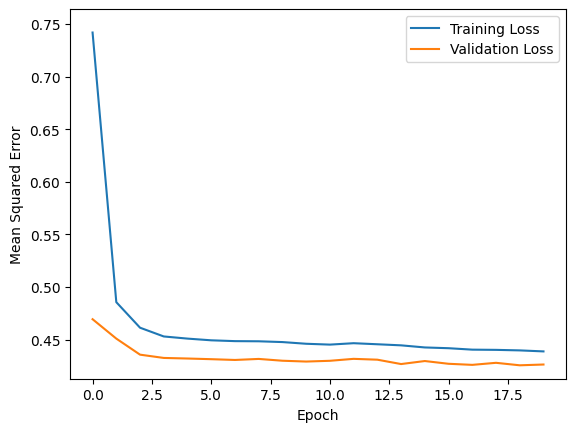

In [26]:
# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size, label_name, validation_split)

# Plot the Loss curves
plot_loss_curve(epochs, mse, history['val_mean_squared_error'])

Evaluate the Deep Neural Network.

In [27]:
# Evaluate dnn model against test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(np.array(test_features.pop(label_name)))
print("\nEvaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size, return_dict=True)


Evaluate the new model against the test set:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4568 - mean_squared_error: 0.4568 


{'loss': 0.4749816954135895, 'mean_squared_error': 0.4749816954135895}